In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from utils.TD_NN import TemporalDifferenceNN
from utils.NeuralNet import TwoHiddenLayerNN

from utils import Benchmarking

# seed = 42
# torch.manual_seed(seed)

In [2]:
housedata = torch.tensor(np.loadtxt('data\\readyhousedata.txt', delimiter=','), dtype=torch.float32)

X = housedata[:, :-1]
y = housedata[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Parameters for TD
num_samples, num_features = X_train.shape
num_samples_test, num_features_test = X_test.shape
P = torch.ones((num_samples, num_samples)) / num_samples # Equal probability to move to any state

identity = lambda x : x

In [4]:
# Initialise classes
td_sgd = TemporalDifferenceNN(
    optimizer='sgd',
    input_size=num_features,
    learning_rate=0.01,
    P=P,
    gamma=0
)

td_adam = TemporalDifferenceNN(
    optimizer='adam',
    input_size=num_features,
    learning_rate=0.01,
    P=P,
    gamma=0.2
)

nn_sgd = TwoHiddenLayerNN(
    input_size=num_features,
    optimizer='sgd',
    learning_rate=0.01,
)

nn_adam = TwoHiddenLayerNN(
    input_size=num_features,
    optimizer='adam',
    learning_rate=0.1,
    betas=(0.95, 0.999),
)

In [5]:
iter = 10
# Define noise standard deviation
noise_std = 0.1

# Initialize tensors to store predictions over iterations
Y_pred_td_sgd = torch.zeros(num_samples_test, iter)
Y_pred_td_adam = torch.zeros(num_samples_test, iter)
Y_pred_nn_sgd = torch.zeros(num_samples_test, iter)
Y_pred_nn_adam = torch.zeros(num_samples_test, iter)

Y_pred_td_sgd_noisy = torch.zeros(num_samples_test, iter)
Y_pred_td_adam_noisy = torch.zeros(num_samples_test, iter)
Y_pred_nn_sgd_noisy = torch.zeros(num_samples_test, iter)
Y_pred_nn_adam_noisy = torch.zeros(num_samples_test, iter)

# Add Gaussian noise to the test set
for i in range(iter):
    # Reset model weights
    td_sgd.reset()
    td_adam.reset()
    nn_sgd.reset()
    nn_adam.reset()

    print('--------------------')
    print(f'Iteration {i}:')

    # Train the TD models
    td_sgd.fit(X_train, y_train, epochs=600)
    td_adam.fit(X_train, y_train, epochs=600)

    # Train the NN models
    nn_sgd.fit(X_train, y_train, epochs=600)
    nn_adam.fit(X_train, y_train, epochs=400)

    # Generate noise
    X_test_noisy = X_test + torch.randn(X_test.shape) * noise_std
    
    # TD predictions on original and noisy test sets
    Y_pred_td_sgd[:, i] = td_sgd.predict(X_test).squeeze()
    Y_pred_td_sgd_noisy[:, i] = td_sgd.predict(X_test_noisy).squeeze()
    Y_pred_td_adam[:, i] = td_adam.predict(X_test).squeeze()
    Y_pred_td_adam_noisy[:, i] = td_adam.predict(X_test_noisy).squeeze()

    # NN predictions on original and noisy test sets
    Y_pred_nn_sgd[:, i] = nn_sgd.predict(X_test).squeeze()
    Y_pred_nn_sgd_noisy[:, i] = nn_sgd.predict(X_test_noisy).squeeze()
    Y_pred_nn_adam[:, i] = nn_adam.predict(X_test).squeeze()
    Y_pred_nn_adam_noisy[:, i] = nn_adam.predict(X_test_noisy).squeeze()


--------------------
Iteration 0
Training finished. Final epoch loss: 92.16223922142616
Training finished. Final epoch loss: 78.78679605630728
Training finished. Final epoch loss: 157.96020889282227
Training finished. Final epoch loss: 177.16600330059345
--------------------
Iteration 1
Training finished. Final epoch loss: 150.771663078895
Training finished. Final epoch loss: 98.3381903721736
Training finished. Final epoch loss: 132.18662291306717
Training finished. Final epoch loss: 616.5173909113958
--------------------
Iteration 2
Training finished. Final epoch loss: 170.19507510845477
Training finished. Final epoch loss: 50.020498972672684
Training finished. Final epoch loss: 150.23403079693134
Training finished. Final epoch loss: 340.94444172198956
--------------------
Iteration 3
Training finished. Final epoch loss: 86.27447799535898
Training finished. Final epoch loss: 50.385203508230354
Training finished. Final epoch loss: 126.98807114821214
Training finished. Final epoch loss:

In [6]:
change_td_sgd = Benchmarking.mean_absolute_diff(Y_pred_td_sgd, Y_pred_td_sgd_noisy)
change_td_adam = Benchmarking.mean_absolute_diff(Y_pred_td_adam, Y_pred_td_adam_noisy)
change_nn_sgd = Benchmarking.mean_absolute_diff(Y_pred_nn_sgd, Y_pred_nn_sgd_noisy)
change_nn_adam = Benchmarking.mean_absolute_diff(Y_pred_nn_adam, Y_pred_nn_adam_noisy)

# Print the results
print(f"Average change for TD-SGD: {torch.mean(change_td_sgd)} ± {torch.std(change_td_sgd) / len(change_td_sgd)}")
print(f"Average change for TD-Adam: {torch.mean(change_td_adam)} ± {torch.std(change_td_adam) / len(change_td_adam)}")
print(f"Average change for L2-SGD: {torch.mean(change_nn_sgd)} ± {torch.std(change_nn_sgd) / len(change_nn_sgd)}")
print(f"Average change for L2-Adam: {torch.mean(change_nn_adam)} ± {torch.std(change_nn_adam) / len(change_nn_adam)}")

Average change for TD-SGD: 3.2333312034606934 ± 0.04532543197274208
Average change for TD-Adam: 8.080495834350586 ± 0.13234317302703857
Average change for L2-SGD: 3.296205997467041 ± 0.05088397115468979
Average change for L2-Adam: 2.973301410675049 ± 0.2518758475780487


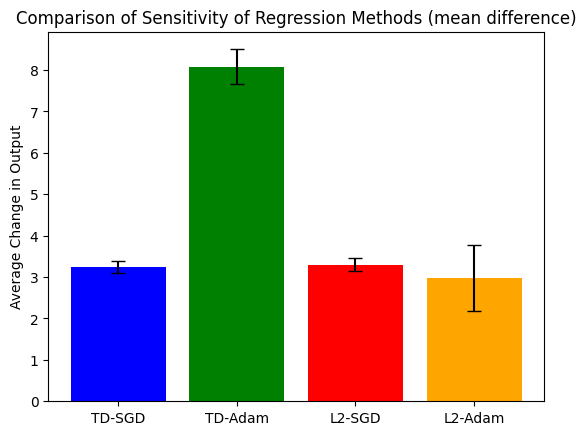

In [7]:
# Plot the changes in predictions
Benchmarking.plot_noise_diff(
    td_sgd=change_td_sgd, 
    td_adam=change_td_adam, 
    nn_sgd=change_nn_sgd, 
    nn_adam=change_nn_adam,
    )

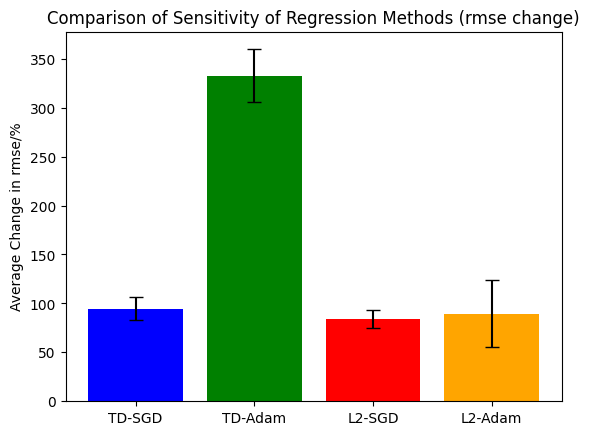

In [8]:
rmse_change_td_sgd =  Benchmarking.mean_rmse_change(y_test, Y_pred_td_sgd, Y_pred_td_sgd_noisy)
rmse_change_td_adam = Benchmarking.mean_rmse_change(y_test, Y_pred_td_adam, Y_pred_td_adam_noisy)
rmse_change_nn_sgd =  Benchmarking.mean_rmse_change(y_test, Y_pred_nn_sgd, Y_pred_nn_sgd_noisy)
rmse_change_nn_adam = Benchmarking.mean_rmse_change(y_test, Y_pred_nn_adam, Y_pred_nn_adam_noisy)

# Plot the changes in predictions
Benchmarking.plot_rmse_diff(
    td_sgd=rmse_change_td_sgd, 
    td_adam=rmse_change_td_adam, 
    nn_sgd=rmse_change_nn_sgd, 
    nn_adam=rmse_change_nn_adam,
    )